**Importing necessary libraries**

In [80]:
import torch
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
from IPython.display import Audio
from sklearn.kernel_approximation import RBFSampler


%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

mps


**Loading the audio**

In [62]:
audio, sr = torchaudio.load('/Users/shreya/Documents/fork-it/assignment2/Task_2/sample_audio.wav')
print("audio shape: ", audio.shape)
print("sample rate: ",{sr})

audio shape:  torch.Size([1, 220500])
sample rate:  {44100}


In [63]:
audio_length = audio.shape[1] / sr
print("audio length is", audio_length, "sec")

audio length is 5.0 sec


In [64]:
audio

tensor([[ 0.0000e+00,  3.0518e-05, -6.1035e-05,  ..., -6.8054e-03,
         -1.2634e-02, -2.0386e-02]])

**Plotting Audio**

In [123]:
def audio_plot(audio, sr,color,title):

    #checking if audio data is 2D array with one channel
    if len(audio.shape) == 2 and audio.shape[0] == 1:
        audio = audio[0]  #extracting single channel

    #in case audio data is 1D array, no need to flatten
    if len(audio.shape) == 1:
        audio = audio.flatten()

    if ax is None:
        plt.figure(figsize=(15, 4))
        ax = plt.gca()
    
    plt.plot(audio, color = color, alpha = 0.7)

    num_samples = audio.shape[0]
    xticks = np.arange(0, num_samples, sr)
    xticklabels = np.arange(0, num_samples / sr, 1)

    plt.xticks(xticks,xticklabels)
    plt.ylim(-0.3,0.3)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.title(title)
    plt.grid()
    plt.show()

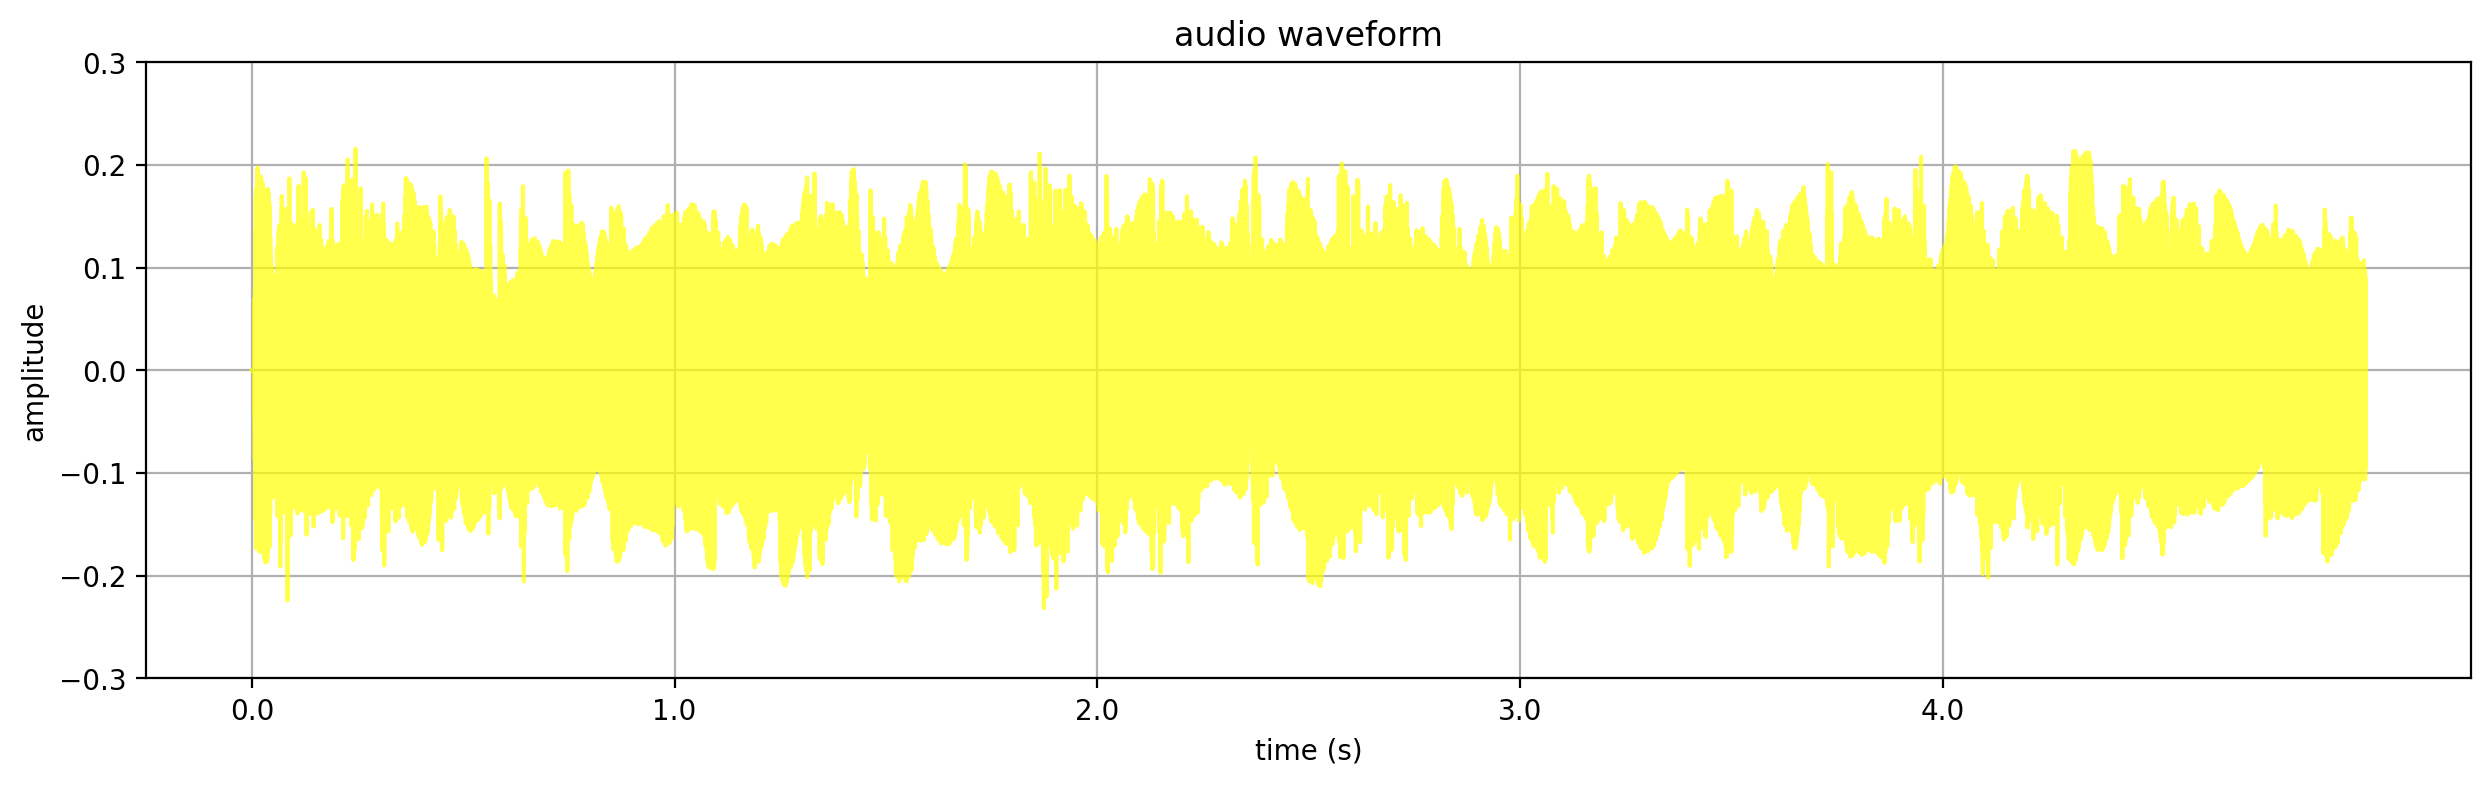

In [71]:
audio_plot(audio, sr,'yellow','audio waveform')

**Using last 2 seconds of the Sample Audio**

In [72]:
audio_trim = audio [:,-2*sr:]
print(audio_trim.shape)
print(audio_trim)

torch.Size([1, 88200])
tensor([[ 0.0151, -0.0408, -0.0940,  ..., -0.0068, -0.0126, -0.0204]])


**Plotting the last 2 seconds of the Sample Audio**

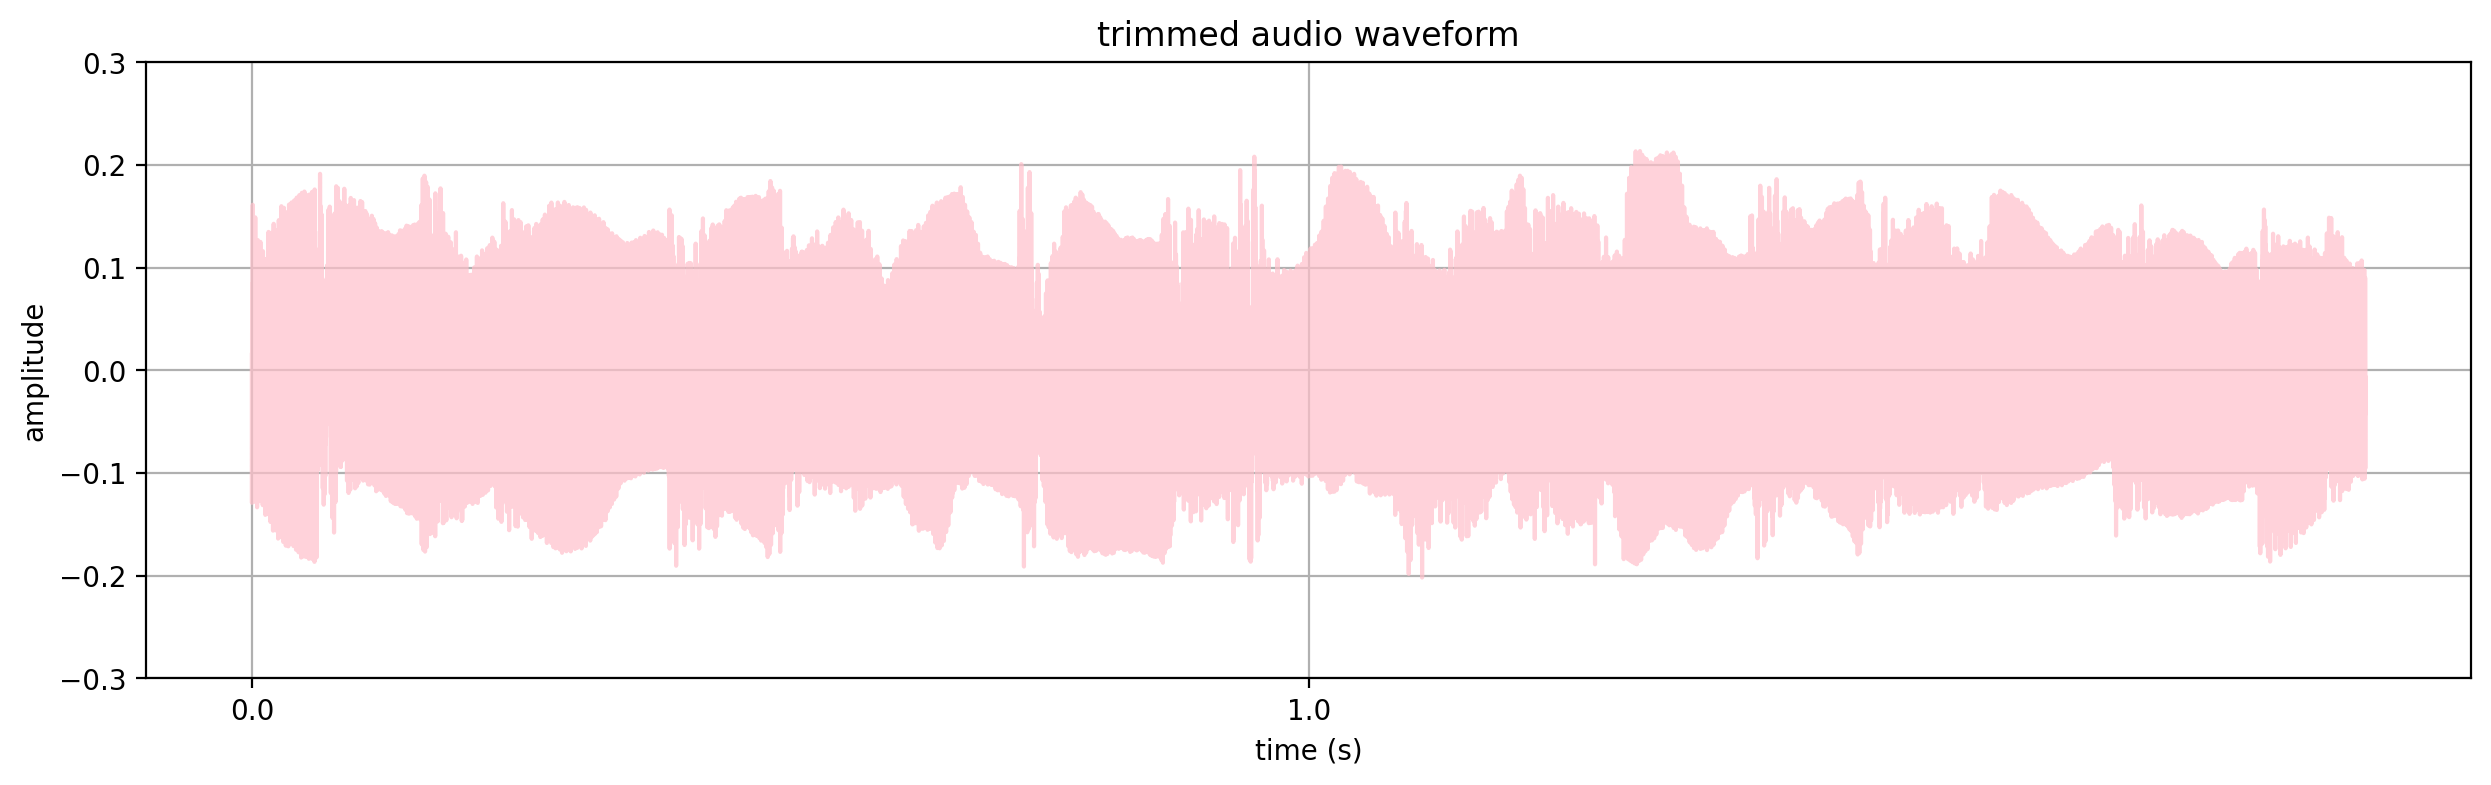

In [73]:
audio_plot(audio_trim, sr, 'pink', 'trimmed audio waveform')

**Normalization, Scaling and Shifting**

In [75]:
X = torch.arange(0, audio_trim.shape[1]).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


**Playing the audio**

In [78]:
Audio(audio, rate=sr)


**Playing the trimmed audio**

In [79]:
Audio(audio_trim, rate=sr)


**Transforming input features into new features using Random Fourier Features**

In [81]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2), random_state=13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)
    

In [82]:
X_rff = create_rff_features(X, 5000, 0.008)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [85]:
print("X_rff shape:", X_rff.shape)
print("audio_trim shape:", audio_trim.shape)


X_rff shape: torch.Size([88200, 5000])
audio_trim shape: torch.Size([1, 88200])


In [87]:
#reshaping audio_trim to be a 1D tensor
audio_trim_1D = audio_trim.squeeze()

#checking the shapes
print(f"X_rff shape: {X_rff.shape}")
print(f"audio_trim_1d shape: {audio_trim_1D.shape}")

X_rff shape: torch.Size([88200, 5000])
audio_trim_1d shape: torch.Size([88200])


**Fitting a linear model over the expanded feature domain**

In [89]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio_trim_1D)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


**Saving the predicted audio**

In [90]:
soundfile.write('pred_audio.wav', pred_audio, sr)

In [91]:
print(pred_audio)
print(audio)

[-0.08306604 -0.07054751 -0.05531597 ...  0.01728127  0.01008498
 -0.00305414]
tensor([[ 0.0000e+00,  3.0518e-05, -6.1035e-05,  ..., -6.8054e-03,
         -1.2634e-02, -2.0386e-02]])


**Playing the predicted audio**

In [93]:
Audio(pred_audio, rate=sr)

In [99]:
#flattening audio to 1D
audio_flat = audio_trim.numpy().flatten()

**Computing Reconstruction Losses using L1 and L2 norms**

In [103]:
# checking if the lengths match (debugging step)
print(pred_audio.shape, audio_flat.shape)

L2_norm = np.linalg.norm(pred_audio - audio_flat)
L1_norm = np.linalg.norm(pred_audio - audio_flat, ord=1)

print("L1 Norm", L1_norm)
print("L2 Norm:", L2_norm)

(88200,) (88200,)
L1 Norm 4197.2573
L2 Norm: 17.423702


**Plotting Reconstructed Audio**

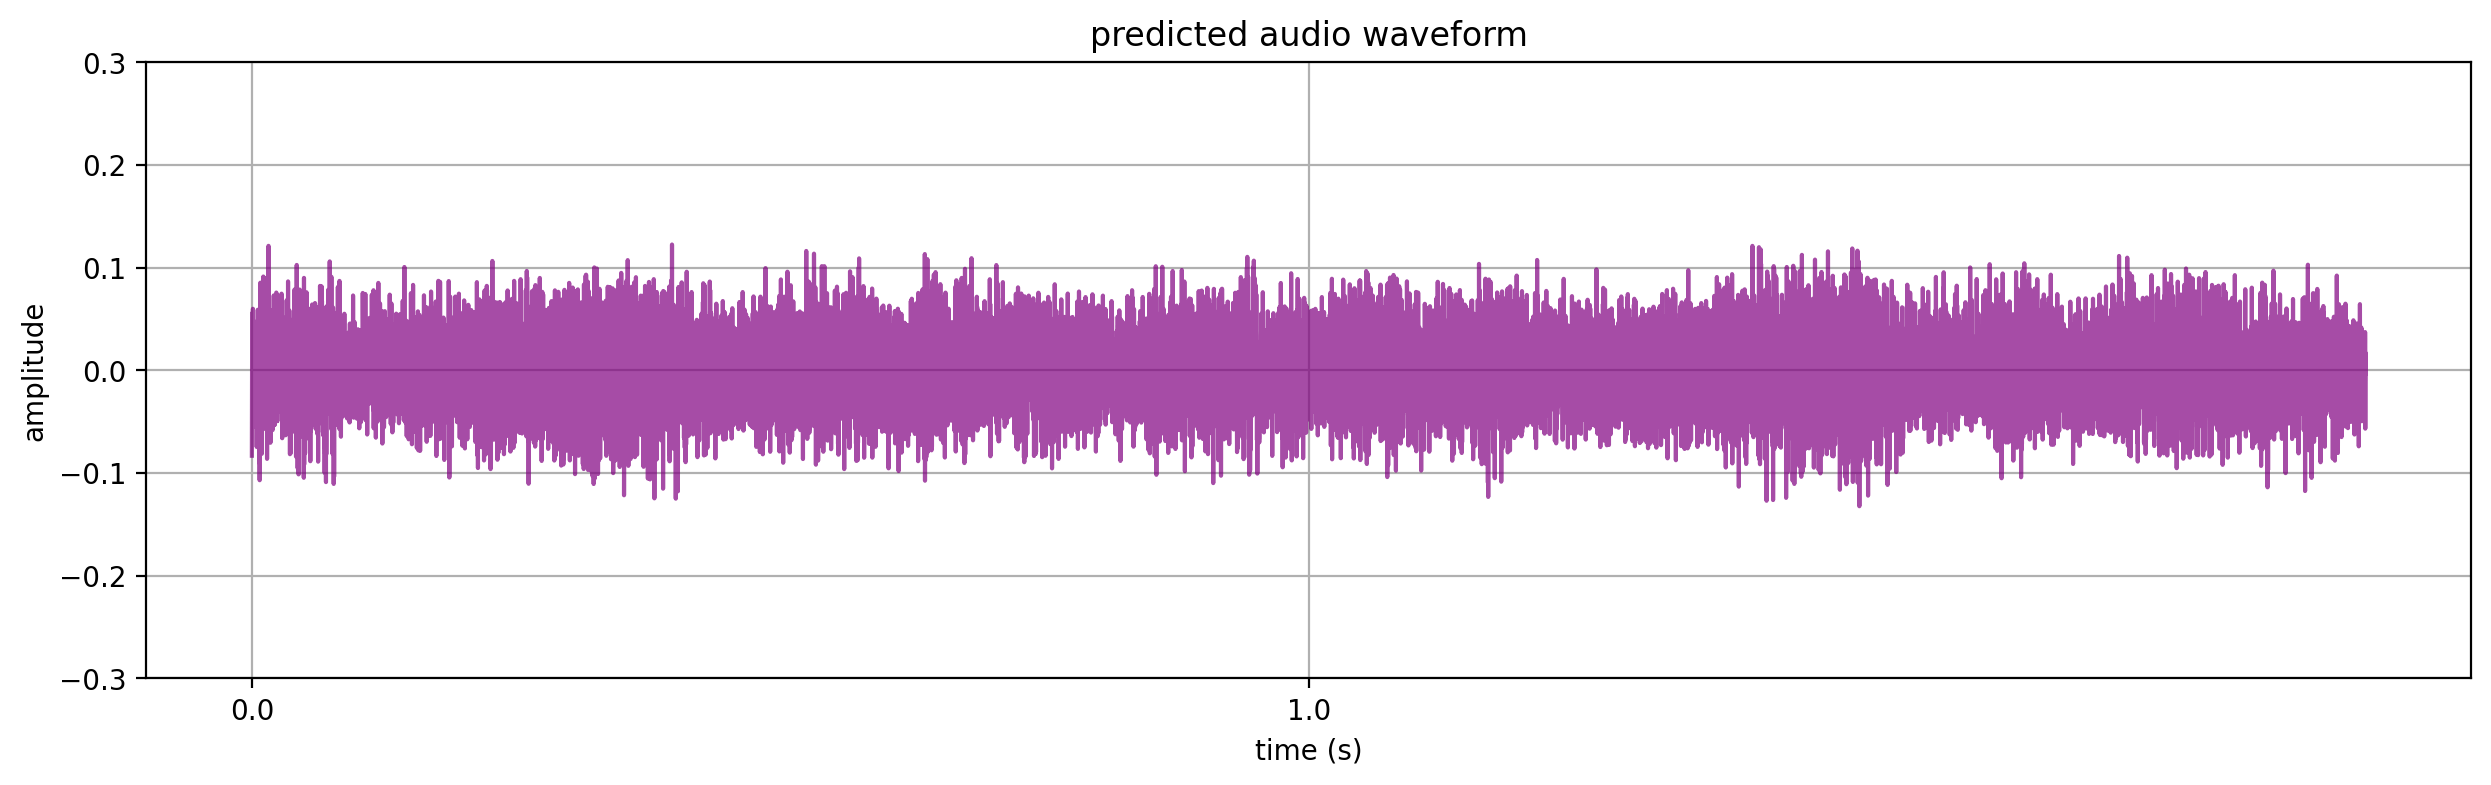

In [108]:
audio_plot(pred_audio, sr, 'purple', 'predicted audio waveform')

**Comparing the plots of original audio and reconstructed audio**

In [120]:
def plot_original_and_reconstructed(original_audio, reconstructed_audio, sr):
    plt.figure(figsize=(15, 8))

    #plotting on same axis
    ax = plt.gca()

    #ploting original audio
    audio_plot(original_audio, sr, 'blue', 'original audio waveform')

    #ploting reconstructed audio
    audio_plot(reconstructed_audio, sr, 'orange', 'reconstructed audio waveform')

    plt.title('original vs reconstructed audio waveforms')
    plt.tight_layout()
    plt.show()

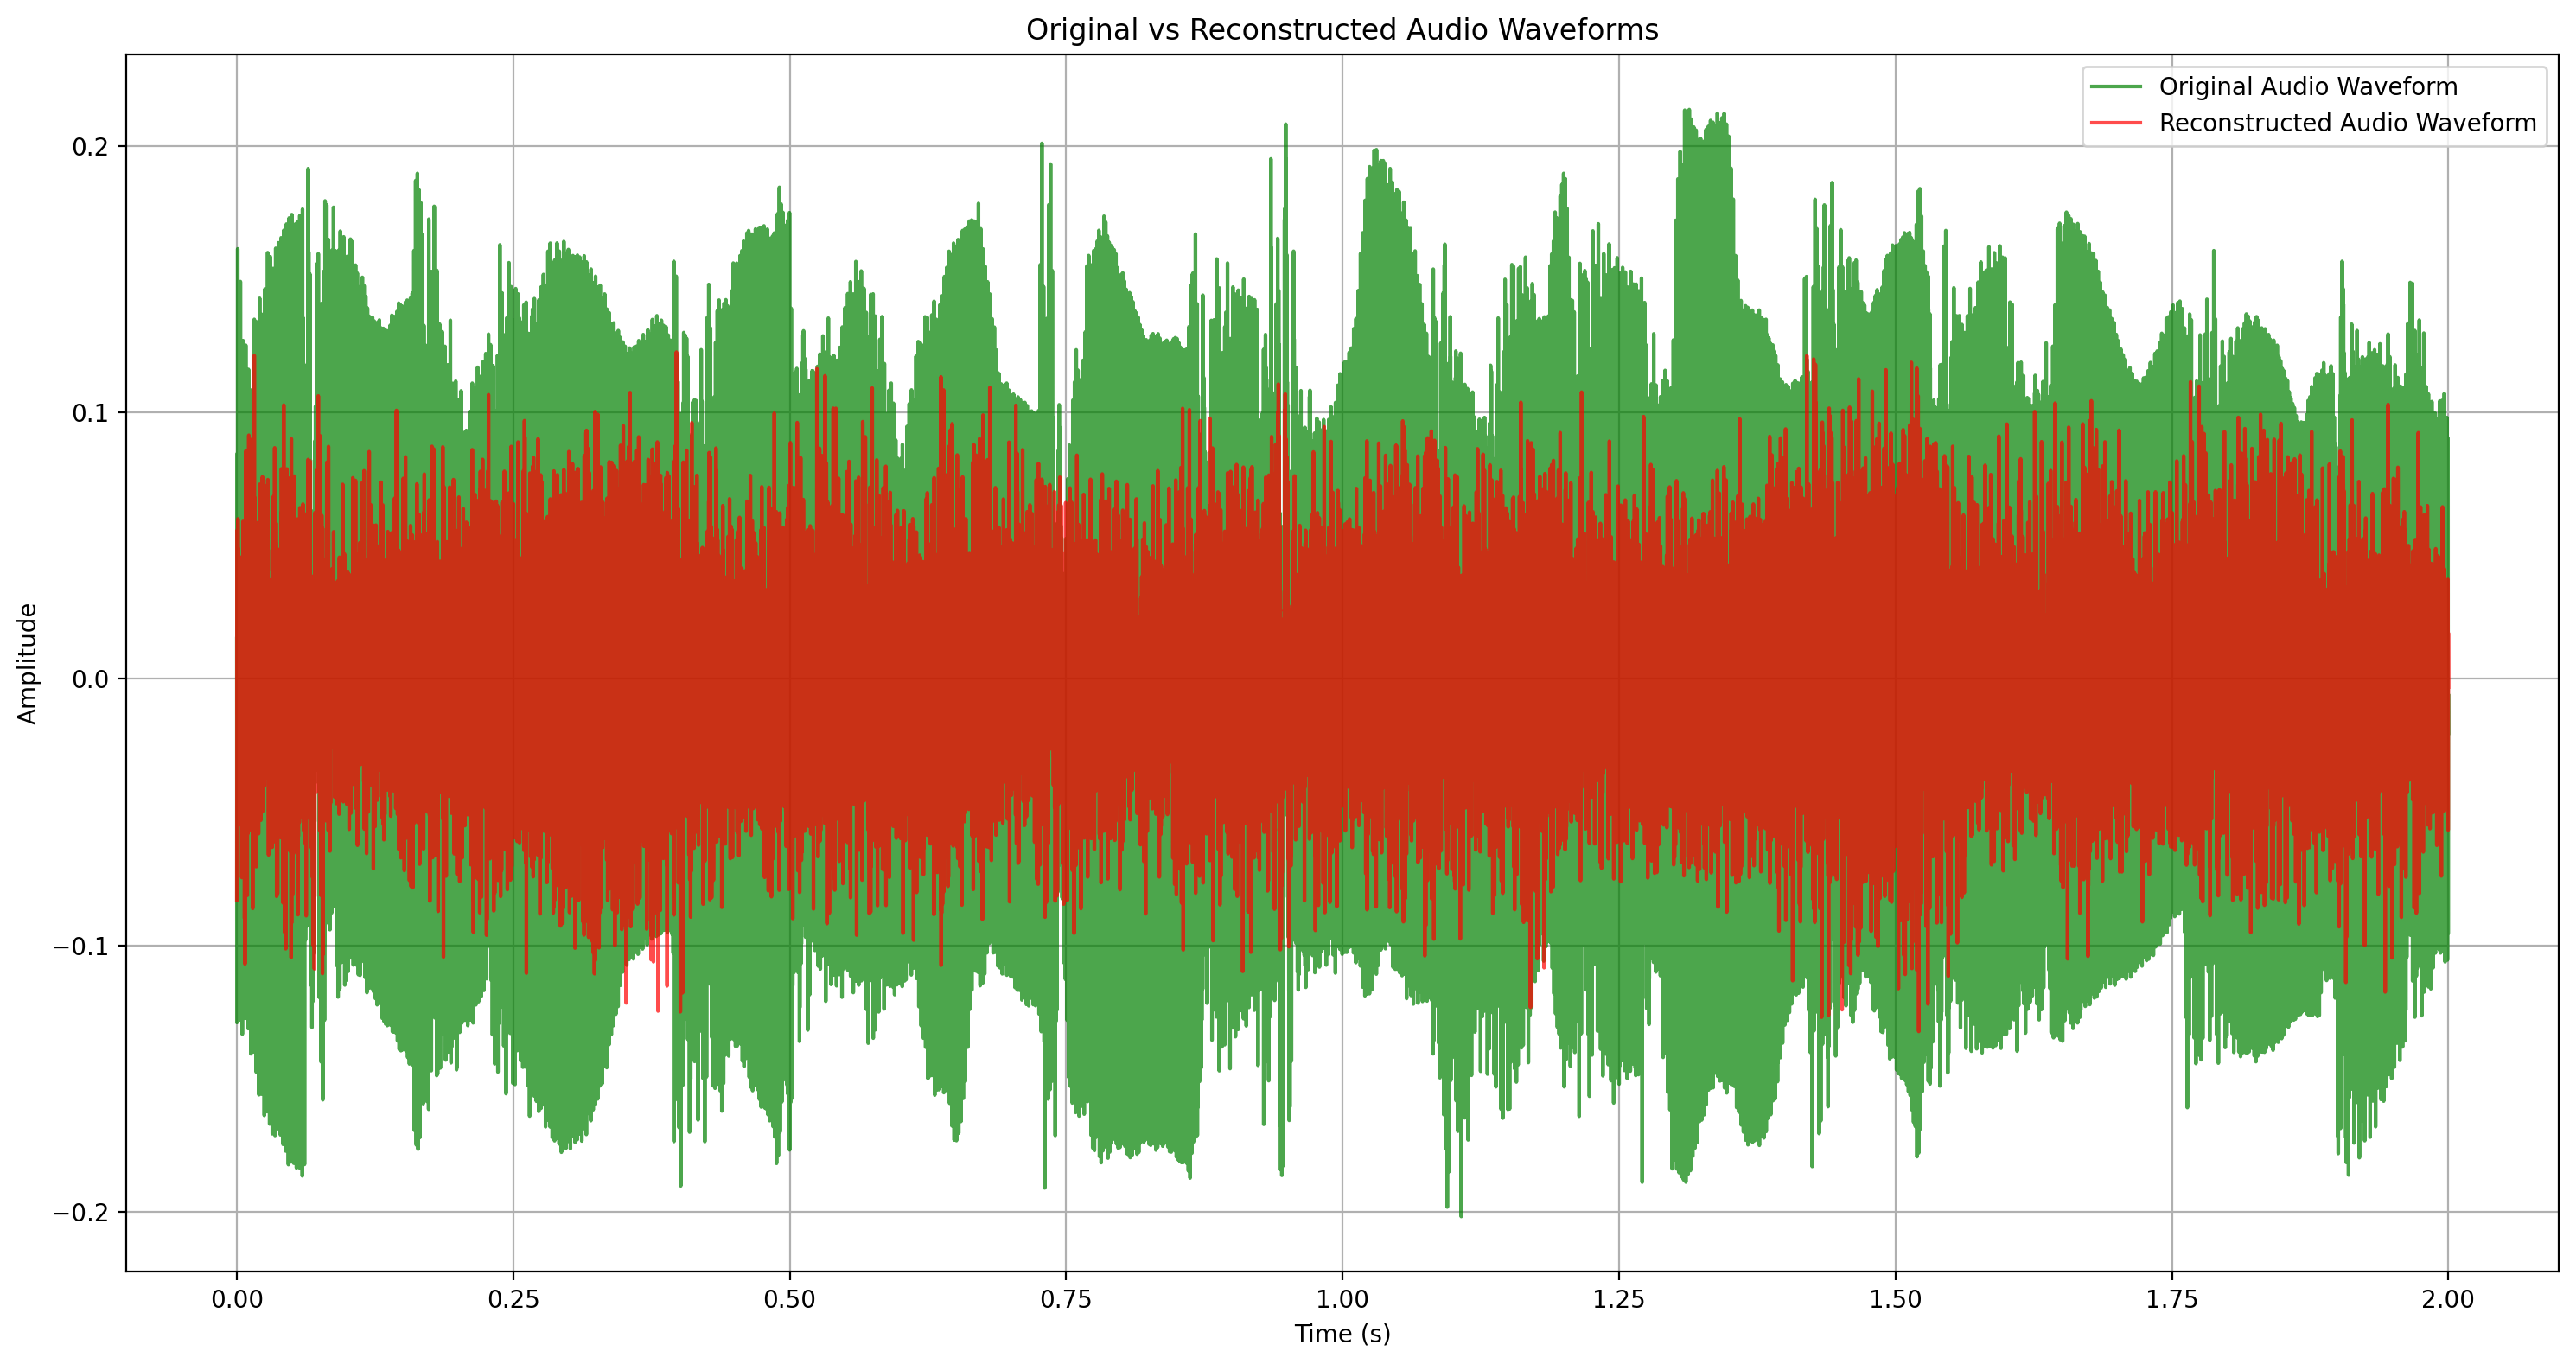

In [119]:
import matplotlib.pyplot as plt
import numpy as np

def audio_plot(ax, audio, sr, color, label):
    # Flatten audio data if it's multi-dimensional
    audio = audio.flatten()
    
    # Generate time axis in seconds
    time_axis = np.arange(len(audio)) / sr
    
    # Plot the audio data
    ax.plot(time_axis, audio, color=color, alpha=0.7, label=label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)

def plot_original_and_reconstructed(original_audio, reconstructed_audio, sr):
    plt.figure(figsize=(15, 8))

    # Create a single axis to plot both audio signals
    ax = plt.gca()

    # Plot original audio
    audio_plot(ax, original_audio, sr, 'green', 'Original Audio Waveform')

    # Plot reconstructed audio
    audio_plot(ax, reconstructed_audio, sr, 'red', 'Reconstructed Audio Waveform')

    plt.title('Original vs Reconstructed Audio Waveforms')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming original_audio and reconstructed_audio are 1D numpy arrays or tensors
plot_original_and_reconstructed(audio_trim_1D, pred_audio, sr)
